/tmp/ipykernel_69739/2795964684.py:68: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  trop_t=ds['TROPT'][:]
/tmp/ipykernel_69739/2795964684.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  merra2_lon=ds['lon'][:]
/tmp/ipykernel_69739/2795964684.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this war

[76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116]
[ 91  92  93  94  95  96  97  98  99 100]


/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


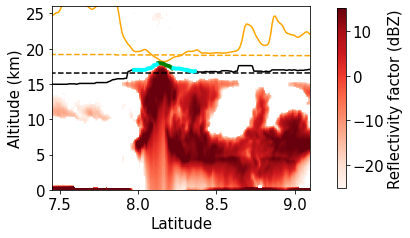

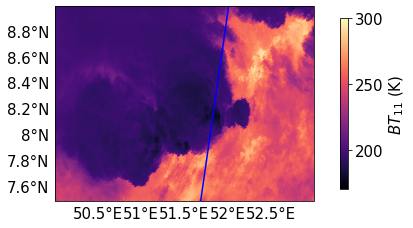

In [1]:
# this python script is to visualize the OT case with CloudSat overpass
# case on Jun 1st,2007, CloudSat-2007152204455_05818_36217

import numpy as np
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
import netCDF4 as nc
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.ndimage import gaussian_filter

planck_c1=1.191042e8
planck_c2=1.4387752e4
hour_scp=22

cldclass_fname='/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-CLDCLASS-LIDAR/2007/2007152204455_05818_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E02_F00.hdf'
geoprof_fname='/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-GEOPROF/2007/2007152204455_05818_CS_2B-GEOPROF_GRANULE_P1_R05_E02_F00.hdf'
merra2_tfname='/data/keeling/a/yulanh/c/MERRA-2/2007/MERRA2_300.inst1_2d_asm_Nx.20070601.nc4'
myd02_fname='/data/gdi/e/MODIS/MYD021KM/2007/152/MYD021KM.A2007152.2220.061.2018040010730.hdf'
myd03_fname='/data/gdi/e/MODIS/MYD03/2007/152/MYD03.A2007152.2220.061.2018039095050.hdf'

hdf=HDF(cldclass_fname,SDC.READ)
vs=hdf.vstart()

cldlat=vs.attach('Latitude')
cldlat=cldlat[:]
cldlat=np.array(cldlat)
cldlon=vs.attach('Longitude')
cldlon=cldlon[:]
cldlon=np.array(cldlon)
cldtime=vs.attach('Profile_time')
cldtime=cldtime[:]
cldtime=np.array(cldtime)
cldlayer=vs.attach('Cloudlayer')
cldlayer=cldlayer[:]
cldlayer=np.array(cldlayer)

#cldtop =vs.attach('CloudLayerTop')
#cldtop =cldtop[:]
#cldtop =np.array(cldtop)
vs.end()
hdf.close()
hdf=SD(cldclass_fname)
cldhgt=hdf.select('Height')
cldhgt=cldhgt[:]/1000.0
cldtop =hdf.select('CloudLayerTop')
cldtop =cldtop[:]

#=== read radar reflectivity factor ===

hdf=SD(geoprof_fname,SDC.READ)
radar_ze=hdf.select('Radar_Reflectivity')
radar_ze=radar_ze[:,:]

ind=np.where((cldlat > 7.45) & (cldlat < 9.1) & (cldlon > 0))[0]

radar_ze_1=radar_ze[ind,:]/100.

radar_ze_2= radar_ze_1.T
radar_ze_2=np.flip(radar_ze_2,axis=1)
radar_ze_2[radar_ze_2 < -28]=np.nan

#=== read merra2 ====
ds=nc.Dataset(merra2_tfname)
trop_t=ds['TROPT'][:]
merra2_lon=ds['lon'][:]
merra2_lat=ds['lat'][:]
trop_b=ds['TROPPB'][:]
PS=ds['PS'][:]
TS=ds['TS'][:]
#== T to H ==
R=8.3143
M=0.02896
g=9.807
Lb=-0.0065 #K/m
h0=0.0
C1=0-R*Lb/(g*M)
C2=trop_b/PS
C3=C2**C1
trop_h=(TS*(C2**C1-1)/Lb+h0)/1000.0

# read MODIS data
hdf=SD(myd02_fname,SDC.READ)
emis_obj=hdf.select('EV_1KM_Emissive')

for key, value in emis_obj.attributes().items():
    if key == 'radiance_offsets':
        add_offset = value  
    if key == 'radiance_scales':
        scale_factor = value
emis11=scale_factor[10]*(emis_obj[10,:,:]-add_offset[10])
bt11=planck_c2/(11.03*np.log(planck_c1/(emis11*11.03**5.0)+1))

emis67=scale_factor[6]*(emis_obj[6,:,:]-add_offset[6])
bt67=planck_c2/(6.72*np.log(planck_c1/(emis67*6.72**5.0)+1))


hdf=SD(myd03_fname,SDC.READ)
mod_lat=hdf.select('Latitude')[:]
mod_lon=hdf.select('Longitude')[:]

fontsz=15
fig,ax=plt.subplots(figsize=[6,6])
extent=[np.min(cldlat[ind]),np.max(cldlat[ind]),np.min(cldhgt),np.max(cldhgt)]
p=ax.imshow(radar_ze_2,vmin=-25,vmax=15,extent=extent,aspect=0.045,cmap='Reds')
ax.set_ylim([0,26])
ax.set_xlabel('Latitude',size=fontsz)
ax.set_ylabel('Altitude (km)',size=fontsz)
ax.tick_params(labelsize=fontsz)
cb=plt.colorbar(p,shrink=0.55,pad=0.08) 
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Reflectivity factor (dBZ)',size=15)
#p.xlabel_style={'size':fontsz,'color':'black'}
#p.ylabel_style={'size':fontsz,'color':'black'}

#==== over plot the topmost height ===
cldtop_1=cldtop[ind,:]
cldlat_1=cldlat[ind]
cldlon_1=cldlon[ind]
cldlayer_1=cldlayer[ind]

cldtop_track=np.zeros((len(ind)),'f')
trop_H_track=np.zeros((len(ind)),'f')
trop_T_track=np.zeros((len(ind)),'f')

#=== colocation between MODIS and CloudSat ===
bt11_track=np.zeros((len(ind)),'f')
bt67_track=np.zeros((len(ind)),'f')

for i in range(len(ind)):
    tpcldtop=cldtop_1[i,:]
    cldtop_track[i]=tpcldtop[cldlayer_1[i]-1]

    tpcldlon=cldlon[i][0]
    tpcldlat=cldlat[i][0]
    lon_scp=round((tpcldlon+180)/0.625)
    lat_scp=round((tpcldlat+90)/0.5)
    trop_H_track[i]=trop_h[hour_scp,lat_scp,lon_scp]
    trop_T_track[i]=trop_t[hour_scp,lat_scp,lon_scp]
    
    adff=np.abs(mod_lon-cldlon_1[i][0])+np.abs(mod_lat-cldlat_1[i][0])
    matind=np.argwhere (adff == np.min(adff))[0]
    bt11_track[i] = bt11[matind[0],matind[1]]
    bt67_track[i] = bt67[matind[0],matind[1]]

#== to find OT based on second deri method
bt11_track=gaussian_filter(bt11_track,sigma=1)
btind=np.where(bt11_track == np.min(bt11_track))[0]
btr=np.flip(bt11_track[0:btind[0]+1])
btl=bt11_track[btind[0]:len(bt11_track)+1]
btr2=np.gradient(np.gradient(btr))
btindr2=np.where(btr2 <=0)[0]
btl2=np.gradient(np.gradient(btl))
btindl2=np.where(btl2 <=0)[0]
otind=np.arange(btindr2[0]+btindl2[0])+btind[0]-btindr2[0]

#=== obtain cirrus ====
indcil=np.arange(otind[0]-btind[0]+20)+btind[0]-20
indcir=np.arange(btind[0]+20-otind[len(otind)-1])+otind[len(otind)-1]+1
print(indcil)
print(indcir)
print(otind)

p1=ax.plot(cldlat_1,cldtop_track,color='black',linestyle='solid')

#=== to plot tropopause height===
p2=ax.plot(cldlat_1,trop_H_track,color='black',linestyle='dashed')
p3=ax.plot(cldlat_1,trop_T_track/10.0,color='orange',linestyle='dashed')
p4=ax.plot(cldlat_1,bt11_track/10.0,color='orange',linestyle='solid')
p5=ax.plot(cldlat_1[otind],cldtop_track[otind],color='green',linestyle='solid',linewidth=4)
p6=ax.plot(cldlat_1[indcil],cldtop_track[indcil],color='cyan',linestyle='solid',linewidth=4)
p7=ax.plot(cldlat_1[indcir],cldtop_track[indcir],color='cyan',linestyle='solid',linewidth=4)


fig,ax =plt.subplots(figsize=([5,5]),subplot_kw={'projection': ccrs.PlateCarree()},constrained_layout=True)
img_extent=(50,52,7.5,10)
mod_lon1=mod_lon.T
mod_lat1=mod_lat.T
bt11_1=bt11.T
p1=ax.plot(cldlon_1,cldlat_1,color='blue')
p0=ax.pcolormesh(mod_lon1,mod_lat1,bt11_1,cmap='magma',vmin=170,vmax=300)
ax.set_aspect(1.5)
ax.set_xlim([50,53])
ax.set_ylim([7.5,9.0])
gl=ax.gridlines(draw_labels=True,linestyle='None')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xlines=False
gl.ylines=False
gl.xlabel_style={'size':fontsz,'color':'black'}
gl.ylabel_style={'size':fontsz,'color':'black'}

cb=plt.colorbar(p0,shrink=0.60,pad=0.1) 
cb.ax.tick_params(labelsize=fontsz)
cb.set_label(label='$BT_{11}$ (K)',size=fontsz)

In [25]:


cldtime1=cldtime[ind]

#print(trop_t.shape,trop_t[23,0,0],merra2_lon[408],merra2_lat[180])
#print(cldlon[0],cldlat[0][0])
#print(np.round((cldlon[0]+180)/0.625)[0],round((cldlat[0][0]+90)/0.5))
adff=np.abs(mod_lon-cldlon_1[50][0])+np.abs(mod_lat-cldlat_1[50][0])
ind=np.argwhere (adff == np.min(adff))[0]
print(ind,cldlon_1[50][0],cldlat_1[50][0],mod_lon[86,876],mod_lat[86,876],np.min(adff),adff[0,0])
print(ind[0],ind[1])

bt11_track=gaussian_filter(bt11_track,sigma=1)
btind=np.where(bt11_track == np.min(bt11_track))[0]
btr=np.flip(bt11_track[0:btind[0]+1])
btl=bt11_track[btind[0]:len(bt11_track)+1]
btr2=np.gradient(np.gradient(btr))
btindr2=np.where(btr2 <=0)[0]
btl2=np.gradient(np.gradient(btl))
btindl2=np.where(btl2 <=0)[0]
otind=np.arange(btindr2[0]+btindl2[0])+btind[0]-btindr2[0]-1
print(bt11_track[otind])
#== for cirrus edge ====
btlci=bt11_track[(btind[0]+btindl2[0]+1):(btind[0]+20)]
btrci=bt11_track[(btind[0]-20):(btind[0]-btindr2[0])]

print(otind)

[ 85 876] 51.93024444580078 8.61288070678711 51.930485 8.60188 0.0033006668 14.615982
85 876
[192.02832 191.17104 190.3145  189.46667 188.62617 187.78851 186.95465
 186.13828 185.36923 184.6918  184.15823 183.81985 183.71805 183.87756
 184.30351 184.98213 185.88461 186.97168 188.19733]
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102]


In [30]:
indcil=np.arange(otind[0]-btind[0]-20)+btind[0]-20
print(otind[0],btind[0]-20)

91 76
